In [66]:
# importing rampy
import rampy as rp
# and for numpy we will respect the usual name:ß
import numpy as np
# for matplotlib
from dsatools import decomposition
import pandas as pd

import matplotlib.pyplot as plt
from pydantic import BaseModel
import matplotlib.pyplot as plt
from glob import glob
import os

from typing import List

In [2]:
class XRange(BaseModel):
    lower_limit:float
    higher_limit:float

def _select_range(x_range:XRange, data:np.array) -> np.array:
    cond1 = data[:,0] > x_range.lower_limit
    cond2 = data[:,0] < x_range.higher_limit
    cond = cond1 & cond2
    data = data[cond].copy()
    return data

def load_data(filename:str, x_range:XRange=None,  basepath:str="./data") -> np.array:
    # from glob import glob
    import os
    filepath = os.path.join(basepath, f"{filename}")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not exists")
    spectrum = np.genfromtxt(filepath)
    # Flip X-axis
    spectrum = rp.flipsp(spectrum)
    if(x_range != None):
        assert isinstance(x_range, XRange), f"limit_x must be `XRange`"
        spectrum = _select_range(x_range=x_range, data=spectrum)
    return spectrum

# def load_data(filenames:List[str], x_range:XRange=None, basepath:str="./data") -> np.array:
#     import os
#     spectrums = []
#     for f in filenames:
#         # print(f)
#         spectrum = _single_load_data(filename=f, x_range=x_range, basepath=basepath)
#         spectrums.append(spectrum)

#     # avergae
#     spectrums = np.array(spectrums)
#     spectrums = spectrums.mean(axis=0)
#     return spectrums

color_map = {
    0:"tab:blue",
    50:"tab:orange",
    100:"tab:green",
    150:"tab:red",
    200:"tab:purple",
    300:"tab:brown",
    400:"tab:pink",
    500:"tab:gray",
}

In [270]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter, general_gaussian

def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def despike(y:np.array,window_size:int=20) -> np.array:
    ma = window_size//2
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    # print(spikes.any())
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            y_out[i] = np.mean(y[we])
    return y_out


# We need the following packages here:
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Parameters for this case:
lam = 10_000_000 # smoothness
p = 0.05 # asymmetry
# Baseline stimation function:
def baseline_als(y, lam, p, n_epoch=100) -> np.array:
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_epoch):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    corrected_y = y.copy() - z.copy()
    return corrected_y, z


In [271]:
sorted(glob(f"./data/*"))

['./data/0_600_785 nm_60 s_1_2024_03_18_14_46_49_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_18_14_47_57_01.txt',
 './data/0_600_785 nm_60 s_1_2024_03_18_14_49_01_01.txt',
 './data/100_600_785 nm_60 s_1_2024_03_18_14_54_40_01.txt',
 './data/100_600_785 nm_60 s_1_2024_03_18_14_55_42_01.txt',
 './data/100_600_785 nm_60 s_1_2024_03_18_14_56_45_01.txt',
 './data/150_600_785 nm_60 s_1_2024_03_18_14_58_32_01.txt',
 './data/150_600_785 nm_60 s_1_2024_03_18_14_59_34_01.txt',
 './data/150_600_785 nm_60 s_1_2024_03_18_15_00_38_01.txt',
 './data/200_600_785 nm_60 s_1_2024_03_18_15_02_21_01.txt',
 './data/200_600_785 nm_60 s_1_2024_03_18_15_03_25_01.txt',
 './data/200_600_785 nm_60 s_1_2024_03_18_15_04_30_01.txt',
 './data/300_600_785 nm_60 s_1_2024_03_18_15_10_06_01.txt',
 './data/300_600_785 nm_60 s_1_2024_03_18_15_11_07_01.txt',
 './data/300_600_785 nm_60 s_1_2024_03_18_15_12_10_01.txt',
 './data/400_600_785 nm_60 s_1_2024_03_18_15_13_58_01.txt',
 './data/400_600_785 nm_60 s_1_2024_03_18_15_1

In [272]:
glucoses = []
spectrums = []
files = sorted(glob(f"./data/*"))
x_range = XRange(lower_limit=900, higher_limit=1500)
for f in files:
    spectrum = load_data(filename=f, x_range=x_range, basepath="")
    spectrums.append(spectrum)
    filename = os.path.split(f)[1]
    glucose = filename.split("_")[0]
    glucoses.append(int(glucose))


In [273]:
def lower_thres(point:float, ratio:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag - (sign * (mag * ratio)))
    return point

def higher_thres(point:float, ratio:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag + (sign * (mag * ratio)))
    return point

def standardized(data:np.array) -> np.array:
    assert data.ndim == 1
    x = data.copy()
    # x_i = x_i - mean / std
    mean = x.mean()
    std = x.std()
    # print(mean, std)
    x = (x - mean)/std
    return x

def normalization(data:np.array) -> np.array:
    assert data.ndim == 1
    x = data.copy()
    min = x.min()
    max = x.max()
    x = (x - min)/(max - min)
    return x
# normalization(y)

def butter_lowpass_filter(data:np.array, normal_cutoff:float, order:int=1):
    from scipy.signal import butter,filtfilt
    y = data.copy()
    # normal_cutoff = cutoff / (fs * 0.5)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, y)
    return y

    glucoses     measures
0          0  2935.560000
2          0  2950.040000
1          0  2961.333333
23        50  2979.253333
22        50  2982.960000
21        50  2992.786667
6        150  2994.493333
5        100  2997.413333
7        150  3002.226667
10       200  3002.600000
4        100  3003.760000
9        200  3004.666667
11       200  3007.133333
8        150  3010.573333
3        100  3012.106667
12       300  3013.986667
14       300  3014.186667
13       300  3014.960000
17       400  3026.373333
15       400  3029.133333
16       400  3053.093333
18       500  3065.186667
20       500  3070.853333
19       500  3074.853333


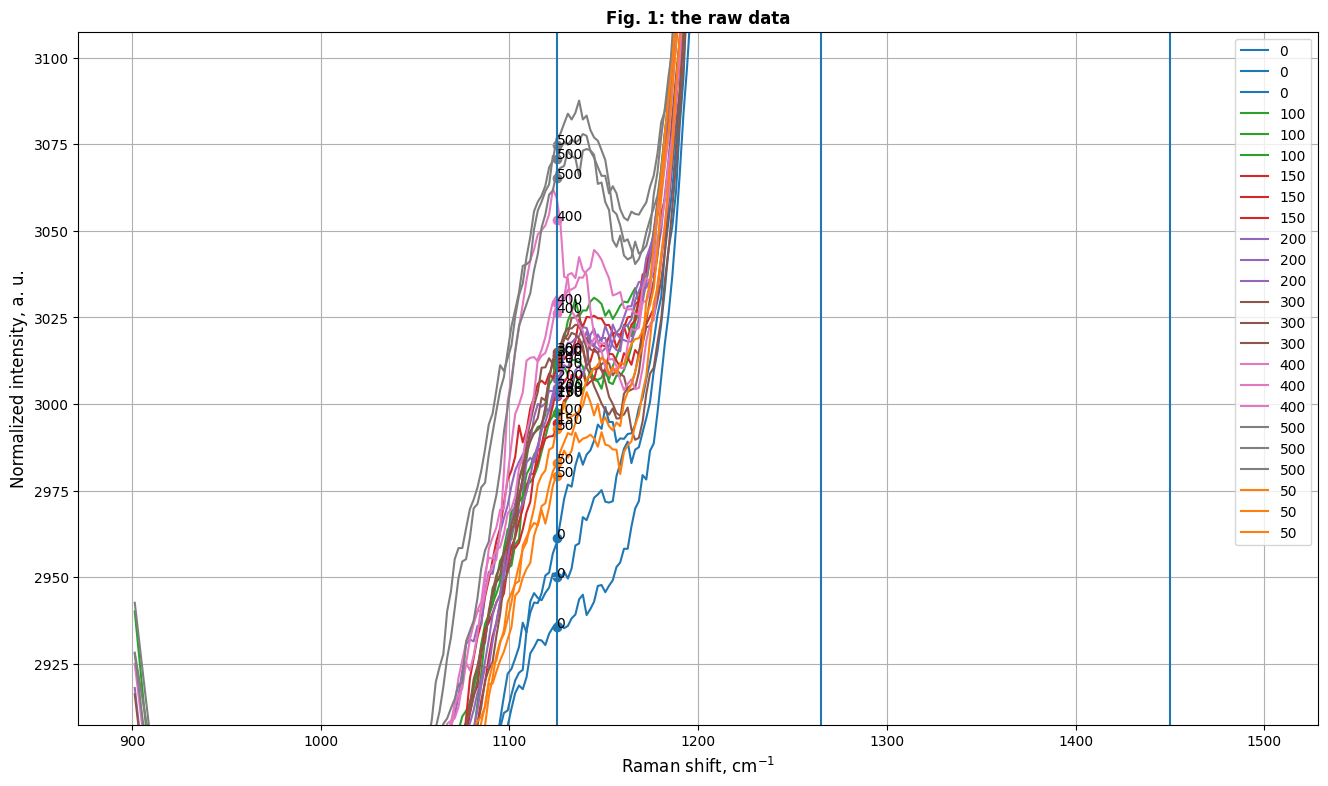

In [379]:
fig,ax = plt.subplots(figsize=(16,9))

ymin = np.inf
ymax = -1 * np.inf
ymin_1125 = np.inf
ymax_1125 = -1 * np.inf
# need to define some fitting regions for the spline
roi1 = np.array([[1000, 1500]])
roi2 = np.array([[1245, 1285],[1430, 1470]])

measures = []
# for idx in np.where( (np.array(glucoses) == 50) |  (np.array(glucoses) == 100) | (np.array(glucoses) == 150) )  [0]:
for idx in range(len(glucoses)):
    # print(idx)
    glucose = glucoses[idx]
    spectrum = spectrums[idx]
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    # y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=2)
    # y = decomposition.hvd(y,order=2, fpar=15)[0]
    # y = decomposition.hvd(np.pad(y,(0,1)),order=2, fpar=15)[0]
    # y = np.delete(y, len(y)-1)
    y = rp.smooth(x,y,method="savgol",window_length=15,polyorder=1)
    # y, base_als = rp.baseline(x, y, roi1, 'als', lam=1e+10, p=1e-5) 

    # y, base_poly = rp.baseline(x, y, roi1, 'rubberband', polynomial_order=2)
    # y, base_poly = rp.baseline(x, y, roi2, 'rubberband', polynomial_order=2)
    # # print(y[:,0].shape)
    # y, baseline = baseline_als(y, lam=1e+12, p=p)
    # y = normalization(y)
    # y = savgol_filter(y.copy(), window_length=15, polyorder=10, deriv=0)
    # y = standardized(y)
    # y_1450 = y[(x > 1445) & (x < 1455)].mean()
    # y = y/y_1450
    ax.plot(x,y,markersize=1, label=glucose, c=color_map[glucose])
    txt_pos_y = y[(x > 1124) & (x < 1126)][0]
    txt_pos_x = 1125
    measure = y[(x > 1120) & (x < 1130)].mean()
    # measure = y[(x > 900) & (x < 910)].mean()

    measures.append(measure)
    # print(glucose, measure)
    # ax.text(x=txt_pos_x, y=txt_pos_y, s=str(glucose))
    ax.text(x=txt_pos_x, y=measure, s=str(glucose))
    ax.scatter(x=txt_pos_x, y=measure,c=color_map[glucose])
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])

    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()
    if txt_pos_y > ymax_1125: ymax_1125 = txt_pos_y
    if txt_pos_y < ymin_1125: ymin_1125 = txt_pos_y

data = {
    "glucoses": glucoses,
    "measures": measures
}
print(pd.DataFrame(data=data).sort_values("measures"))


ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.vlines(x=1265, ymax=ymax, ymin=ymin)
# ax.vlines(x=515, ymax=ymax, ymin=ymin)
ax.vlines(x=1450, ymax=ymax, ymin=ymin)
ax.set_ylim(ymin=lower_thres(ymin_1125,0.01), ymax=higher_thres(ymax_1125,0.01) )
# ax.set_xlim(xmin=1000, xmax=1300)
ax.grid()
ax.legend()
plt.show()

In [171]:
data = {
    "glucoses": glucoses,
    "measures": measures
}
pd.DataFrame(data=data).sort_values("measures")

,glucoses,measures
0,0,2933.000000
2,0,2944.909091
1,0,2957.272727
23,50,2976.090909
22,50,2977.636364
21,50,2995.727273
5,100,2996.636364
9,200,2999.272727
6,150,2999.636364
10,200,3001.000000


In [ ]:
def lower_thres(point:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag - (sign * (mag * 0.01)))
    return point

def higher_thres(point:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag + (sign * (mag * 0.01)))
    return point
higher_thres(10)

In [ ]:
np.sign(-10)

In [ ]:
fig,ax = plt.subplots(figsize=(16,9))

ymin = np.inf
ymax = -1 * np.inf
ymin_1125 = np.inf
ymax_1125 = -1 * np.inf
# need to define some fitting regions for the spline
roi1 = np.array([[0, 1500]])
roi2 = np.array([[1245, 1285],[1430, 1470]])


for glucose,spectrum in zip(glucoses, spectrums):
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    # y, baseline = baseline_als(y, lam=lam, p=p)
    y = standardized(y)
    # y = normalization(y)
    # y, base_als = rp.baseline(x, y, roi2, 'als', lam=10**7, p=0.001) 
    # y, base_poly = rp.baseline(x, y, roi1, 'rubberband', polynomial_order=2)
    # y, base_poly = rp.baseline(x, y, roi2, 'rubberband', polynomial_order=2)
    # # print(y[:,0].shape)
    y = savgol_filter(y.copy(), window_length=15, polyorder=2, deriv=0)
    y_1450 = y[(x > 1440) & (x < 1460)].mean()
    print(y_1450)
    y = y/y_1450
    ax.plot(x,y,markersize=1, label=glucose, c=color_map[glucose])
    txt_pos_y = y[(x > 1124) & (x < 1126)][0]
    txt_pos_x = 1125
    ax.text(x=txt_pos_x, y=txt_pos_y, s=str(glucose))
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])

    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()
    if txt_pos_y > ymax_1125: ymax_1125 = txt_pos_y
    if txt_pos_y < ymin_1125: ymin_1125 = txt_pos_y

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.vlines(x=1265, ymax=ymax, ymin=ymin)
ax.vlines(x=1450, ymax=ymax, ymin=ymin)
ax.set_ylim(ymin=ymin_1125, ymax=ymax_1125)
#ax.set_xlim(xmax=1300, xmin=1000)
ax.grid()
ax.legend()
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(16,9))

ymin = np.inf
ymax = -1 * np.inf
ymin_1125 = np.inf
ymax_1125 = -1 * np.inf
# need to define some fitting regions for the spline
roi1 = np.array([[0, 1500]])
roi2 = np.array([[1245, 1285],[1430, 1470]])


for glucose,spectrum in zip(glucoses, spectrums):
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    # y, baseline = baseline_als(y, lam=lam, p=p)   
    y, base_als = rp.baseline(x, y, roi2, 'als', lam=10**7, p=0.001) 
    # y, base_poly = rp.baseline(x, y, roi1, 'rubberband', polynomial_order=2)
    # y, base_poly = rp.baseline(x, y, roi2, 'rubberband', polynomial_order=2)
    # # print(y[:,0].shape)
    y = savgol_filter(y[:,0].copy(), window_length=30, polyorder=2, deriv=0)
    y_1450 = y[(x > 1440) & (x < 1460)].mean()
    print(y_1450)
    y = y/y_1450
    ax.plot(x,y,markersize=1, label=glucose)
    txt_pos_y = y[(x > 1124) & (x < 1126)][0]
    txt_pos_x = 1125
    ax.text(x=txt_pos_x, y=txt_pos_y, s=str(glucose))
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])

    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()
    if txt_pos_y > ymax_1125: ymax_1125 = txt_pos_y
    if txt_pos_y < ymin_1125: ymin_1125 = txt_pos_y

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.vlines(x=1265, ymax=ymax, ymin=ymin)
ax.vlines(x=1450, ymax=ymax, ymin=ymin)
ax.set_ylim(ymin=ymin_1125-0.2, ymax=ymax_1125+0.2)
#ax.set_xlim(xmax=1300, xmin=1000)
ax.grid()
ax.legend()
plt.show()